In [1]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import keras_tuner as kt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
with open(r'.\News_Dataset_Splits\X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open(r'.\News_Dataset_Splits\X_val.pkl', 'rb') as f:
    X_val = pickle.load(f)

with open(r'.\News_Dataset_Splits\X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open(r'.\News_Dataset_Splits\y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open(r'.\News_Dataset_Splits\y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)

with open(r'.\News_Dataset_Splits\y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

encoder = LabelEncoder()
encoder.fit(np.unique(y_train))
train_labels = encoder.transform(y_train)
val_labels = encoder.transform(y_val)
test_labels = encoder.transform(y_test)
num_classes = len(encoder.classes_)
train_one_hot = keras.utils.to_categorical(train_labels, num_classes=num_classes)
val_one_hot = keras.utils.to_categorical(val_labels, num_classes=num_classes)
test_one_hot = keras.utils.to_categorical(test_labels, num_classes=num_classes)

with open(r'.\embeddingMatrix_News.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

num_tokens = len(embedding_matrix) # total vocabulary +1 or length of embedding matrix
embedding_dim = 300 # dimension of the vector of a single word
MAX_NEWS_LEN = 500 # maximum words in a review

In [3]:
embedding_layer = keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_NEWS_LEN,
    trainable=True)

model = keras.Sequential()
model.add(embedding_layer)
model.add(keras.layers.GlobalAveragePooling1D())

model.add(layers.Dense(units=128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dropout(rate=0.2))

# Output Layer
model.add(layers.Dense(num_classes, activation='softmax'))
model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
NUM_EPOCHS = 12
BATCH_SIZE = 128
history = model.fit(X_train, train_one_hot, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, val_one_hot))

Epoch 1/12
1488/1488 [==============================] - 7s 4ms/step - loss: 1.4348 - accuracy: 0.5711 - val_loss: 0.9903 - val_accuracy: 0.7206
Epoch 2/12
1488/1488 [==============================] - 6s 4ms/step - loss: 0.8660 - accuracy: 0.7481 - val_loss: 0.7749 - val_accuracy: 0.7754
Epoch 3/12
1488/1488 [==============================] - 6s 4ms/step - loss: 0.7006 - accuracy: 0.7974 - val_loss: 0.6665 - val_accuracy: 0.8043
Epoch 4/12
1488/1488 [==============================] - 6s 4ms/step - loss: 0.6092 - accuracy: 0.8209 - val_loss: 0.6180 - val_accuracy: 0.8158
Epoch 5/12
1488/1488 [==============================] - 6s 4ms/step - loss: 0.5532 - accuracy: 0.8362 - val_loss: 0.5794 - val_accuracy: 0.8272
Epoch 6/12
1488/1488 [==============================] - 6s 4ms/step - loss: 0.5129 - accuracy: 0.8472 - val_loss: 0.5589 - val_accuracy: 0.8331
Epoch 7/12
1488/1488 [==============================] - 6s 4ms/step - loss: 0.4814 - accuracy: 0.8553 - val_loss: 0.5431 - val_accuracy:

In [5]:
score = model.evaluate(X_val, val_one_hot, verbose=1)
print("Validation loss: ", score[0])
print("Validation accuracy: ", score[1])

1488/1488 [==============================] - 3s 2ms/step - loss: 0.5134 - accuracy: 0.8481
Validation loss:  0.5134003162384033
Validation accuracy:  0.8481302261352539


In [6]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_actuals = np.argmax(test_one_hot, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_actuals, y_prediction , normalize='pred')
print(result)

1313/1313 [==============================] - 1s 937us/step
[[0.81618294 0.01333957 0.01810487 0.01084599 0.01421801 0.0114643
  0.01365597 0.00782014 0.00796332 0.03001464]
 [0.01605101 0.83969108 0.01786974 0.01181007 0.01624915 0.00833768
  0.0409679  0.04056696 0.00892857 0.00536847]
 [0.02418646 0.01450971 0.80907595 0.01253314 0.04197698 0.01433038
  0.03066603 0.0083089  0.01061776 0.01537335]
 [0.01693052 0.01450971 0.01881025 0.83923837 0.05303543 0.01302762
  0.01341639 0.00488759 0.00820463 0.00707662]
 [0.01759015 0.01146735 0.04138255 0.07061943 0.7666441  0.02475248
  0.02515573 0.00610948 0.01423745 0.01220107]
 [0.0294635  0.01006319 0.02915589 0.01108701 0.05168134 0.90203231
  0.01030187 0.00488759 0.01906371 0.01073694]
 [0.02044855 0.03533817 0.0258641  0.01132803 0.02008576 0.0054716
  0.82055582 0.01441838 0.01423745 0.00414837]
 [0.00703606 0.03931664 0.01058077 0.00674861 0.0051907  0.00312663
  0.01844753 0.90786901 0.00530888 0.00463641]
 [0.02132806 0.01193541

In [7]:
accuracy_score = metrics.accuracy_score(y_prediction, y_actuals)

print('FNN accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_actuals, y_prediction)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_actuals, y_prediction))

FNN accuracy is 84.71%
------------------------------------------------
Confusion Matrix:
      0     1     2     3     4     5     6     7     8     9
0  3712    57    77    45    63    44    57    32    33   123
1    73  3588    76    49    72    32   171   166    37    22
2   110    62  3441    52   186    55   128    34    44    63
3    77    62    80  3482   235    50    56    20    34    29
4    80    49   176   293  3397    95   105    25    59    50
5   134    43   124    46   229  3462    43    20    79    44
6    93   151   110    47    89    21  3425    59    59    17
7    32   168    45    28    23    12    77  3715    22    19
8    97    51    42    47    81    37    70    13  3698    72
9   140    42    82    60    56    30    42     8    79  3659
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      4243
           1       0.84      0.84      0.84    

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

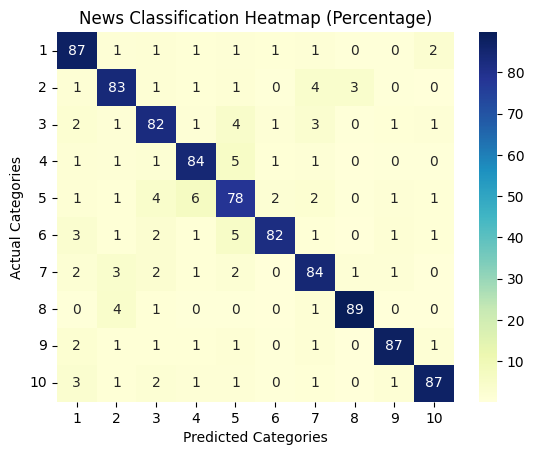

In [10]:
# Create a confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes))
for i in range(len(y_prediction)):
    confusion_matrix[y_actuals[i], y_prediction[i]] += 1

# Normalize the confusion matrix to show percentages
confusion_matrix = 100 * confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

lables = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Create a heatmap with annotation
annot_matrix = np.around(confusion_matrix, 1).astype(int)  # Round percentages to 1 decimal place
ax = sns.heatmap(confusion_matrix, annot=annot_matrix, fmt='d', cmap="YlGnBu", xticklabels=lables, yticklabels=lables)

# Set the title and axis labels
plt.title("News Classification Heatmap (Percentage)")
plt.xlabel("Predicted Categories")
plt.ylabel("Actual Categories")

# Rotate the x-axis labels for better visibility
plt.yticks(rotation=0)

# Display the heatmap
plt.show()

In [11]:
from tensorflow.keras.models import load_model
import os

# Save the model
model_save_path = 'SavedModels/FNN_BestModel.h5'
model.save(model_save_path)

In [13]:
# Load the model
loaded_model = load_model(model_save_path)
score2 = loaded_model.evaluate(X_val, val_one_hot, verbose=1)
print("Validation loss: ", score2[0])
print("Validation accuracy: ", score2[1])

1488/1488 [==============================] - 3s 2ms/step - loss: 0.5134 - accuracy: 0.8481
Validation loss:  0.5134003162384033
Validation accuracy:  0.8481302261352539
